# Bespokefit workshop live session

## Learning objectives

By the end of this workshop you will be able to:

1. Build, configure and save a general BespokeFit optimization workflow
2. Build molecule specific optimization schemas from the general workflow
3. Load QCArchive computed data using OpenFF-QCSubmit as a fitting reference
4. Optimize some bespoke torsion parameters
5. Analyse the results from ForceBalance 
6. Generate reference data locally using xTB on the fly

In [1]:
from openff.qcsubmit.results import TorsionDriveResultCollection
from openff.bespokefit.workflows import BespokeWorkflowFactory
from openff.bespokefit.schema.optimizers import ForceBalanceSchema
from openff.bespokefit.schema.targets import TorsionProfileTargetSchema
from openff.bespokefit.fragmentation import WBOFragmenter
from openff.bespokefit.schema.smirnoff import ProperTorsionSettings, SmirksType
from openff.bespokefit.bespoke import Executor, deserialize_results, serialize_results
from openff.bespokefit.schema.data import BespokeQCData
from openff.qcsubmit.common_structures import QCSpec
from openff.toolkit.topology import Molecule
from qcportal import FractalClient
from pprint import pprint
from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor

## 1. Building the general workflow

BespokeFit aims to provide a reproducible parameter optimization workflow for SMIRNOFF based force fields. As such normal BespokeFit execution starts with a general fitting workflow. This captures every process in the workflow along with any adjustable settings such as how the reference data should be generated. The default workflow is designed to optimize bespoke torsion parameters at the same level of theory as that used in the mainline openff force fields.

Here however we will be starting with a blank workflow and building it up as we go. First, we start with our optimization engine, which is currently only `ForceBalance`. Let's start by creating the ForceBalance optimization schema.

In [2]:
fb = ForceBalanceSchema()
pprint(fb.dict())

{'adaptive_damping': 1.0,
 'adaptive_factor': 0.2,
 'eigenvalue_lower_bound': 0.01,
 'error_tolerance': 1.0,
 'extras': {},
 'finite_difference_h': 0.01,
 'gradient_convergence_threshold': 0.01,
 'initial_trust_radius': -0.25,
 'job_type': 'optimize',
 'max_iterations': 10,
 'minimum_trust_radius': 0.05,
 'n_criteria': 2,
 'normalize_weights': False,
 'objective_convergence_threshold': 0.01,
 'penalty_additive': 1.0,
 'penalty_type': 'L2',
 'step_convergence_threshold': 0.01,
 'type': 'ForceBalance'}


There are many options here and in some cases, it might not be clear what a valid input is. For example, what other penalty types could we use? 

As we use [pydantic](https://github.com/samuelcolvin/pydantic) to define our models we can check the schema which will give a short description for each of the properties and information on the acceptable inputs. This should also help catch errors ahead of run time as the schema is validated when new parameters are assigned.

In [3]:
pprint(fb.schema())

{'description': 'A class containing the main ForceBalance optimizer settings '
                'to use during an\n'
                'optimization.\n'
                '\n'
                'Priors and target definitions are stored separately as part '
                'of an\n'
                '``OptimizationSchema``.',
 'properties': {'adaptive_damping': {'default': 1.0,
                                     'description': 'A damping factor that '
                                                    'restraints the trust '
                                                    'radius to trust0.',
                                     'exclusiveMinimum': 0,
                                     'title': 'Adaptive Damping',
                                     'type': 'number'},
                'adaptive_factor': {'default': 0.2,
                                    'description': 'The amount to change the '
                                                   'step size by in the event '
         

We can now see that `penalty_type` only accepts the values `L2` and `L1` so lets try something else and see what happens.

In [4]:
fb.penalty_type = "L3"

ValidationError: 1 validation error for ForceBalanceSchema
penalty_type
  unexpected value; permitted: 'L1', 'L2' (type=value_error.const; given=L3; permitted=('L1', 'L2'))

We get an informative error message before even running the workflow, now we set it to `L1`.

In [5]:
fb.penalty_type = "L1"

Now we can start to build up our workflow and see what other pieces we might need. Note by default the workflow is set up for torsion drives so here we remove the defaults and pass in our new ForceBalance optimizer schema.

In [6]:
workflow = BespokeWorkflowFactory(fragmentation_engine=None, optimizer=fb, parameter_settings=[], target_smirks=[], target_templates=[])
pprint(workflow.dict())

{'expand_torsion_terms': True,
 'fragmentation_engine': None,
 'generate_bespoke_terms': True,
 'initial_force_field': 'openff_unconstrained-1.3.0.offxml',
 'optimizer': {'adaptive_damping': 1.0,
               'adaptive_factor': 0.2,
               'eigenvalue_lower_bound': 0.01,
               'error_tolerance': 1.0,
               'extras': {},
               'finite_difference_h': 0.01,
               'gradient_convergence_threshold': 0.01,
               'initial_trust_radius': -0.25,
               'job_type': 'optimize',
               'max_iterations': 10,
               'minimum_trust_radius': 0.05,
               'n_criteria': 2,
               'normalize_weights': False,
               'objective_convergence_threshold': 0.01,
               'penalty_additive': 1.0,
               'penalty_type': 'L1',
               'step_convergence_threshold': 0.01,
               'type': 'ForceBalance'},
 'parameter_settings': [],
 'target_smirks': [],
 'target_templates': []}


Bespokefit makes extensive use of the fantastic [openff-fragmenter](https://github.com/openforcefield/openff-fragmenter) package where possible to reduce the cost of QM torsion drives as they can quickly become very expensive for large drug-like molecules. Here we will add the `WBO` based fragmentation scheme to the pipeline.

In [7]:
fragmenter = WBOFragmenter()
workflow.fragmentation_engine = fragmenter
pprint(fragmenter.dict())

{'keep_non_rotor_ring_substituents': True,
 'target_bond_smarts': None,
 'type': 'WBOFragmenter',
 'wbo_threshold': 0.03}


We also need a target template, these describe which targets we would like to fit against and are unique to the chosen optimizer. In this case, we want to optimize torsion parameters to torsion drives so we want the `TorsionProfileTargetSchema` we can also change some target specific settings related to the optimization here.

In [8]:
target = TorsionProfileTargetSchema()
workflow.target_templates = [target, ]
pprint(target.dict())

{'attenuate_weights': True,
 'energy_cutoff': 10.0,
 'energy_denominator': 1.0,
 'extras': {},
 'reference_data': None,
 'type': 'TorsionProfile',
 'weight': 1.0}


The last two parts to add to the workflow describe which general types of parameters such as bonds or angles should be targeted and which component of the parameter class should be optimised. This could be the force constant or equilibrium value and how they should be restrained during fitting.

In [9]:
# let the workflow know we want to optimize the proper torsion parameters
workflow.target_smirks = [SmirksType.ProperTorsions]
# add the optimization options for these parameters
options = ProperTorsionSettings()
workflow.parameter_settings = [options, ]
pprint(workflow.dict())

{'expand_torsion_terms': True,
 'fragmentation_engine': {'keep_non_rotor_ring_substituents': True,
                          'target_bond_smarts': None,
                          'type': 'WBOFragmenter',
                          'wbo_threshold': 0.03},
 'generate_bespoke_terms': True,
 'initial_force_field': 'openff_unconstrained-1.3.0.offxml',
 'optimizer': {'adaptive_damping': 1.0,
               'adaptive_factor': 0.2,
               'eigenvalue_lower_bound': 0.01,
               'error_tolerance': 1.0,
               'extras': {},
               'finite_difference_h': 0.01,
               'gradient_convergence_threshold': 0.01,
               'initial_trust_radius': -0.25,
               'job_type': 'optimize',
               'max_iterations': 10,
               'minimum_trust_radius': 0.05,
               'n_criteria': 2,
               'normalize_weights': False,
               'objective_convergence_threshold': 0.01,
               'penalty_additive': 1.0,
               'penal

Now we can save our workflow to file to use again later or save for provenance.

In [10]:
workflow.export_workflow("workflow.yaml")

# 2. Build molecule specific schema

Now we can use our general fitting schema to build a molecule specific optimization schema. This schema fully defines the optimization protocol that should be applied to the molecule including information about the reference data generation tasks which are related to the target templates in the general workflow.

Let's load up an SDF file with a congeneric series of ligands from the BACE benchmark system of the Schrodinger JACS study, and select our target molecule.

In [11]:
# load the molecules
ligands = Molecule.from_file("data/bace.sdf")
target_molecule = ligands[7]
target_molecule

NGLWidget()

We can now use the workflow to build the schema. Note that the workflow can accept a list of molecules and produce a corresponding list of bespoke optimization tasks.

In [12]:
schema = workflow.optimization_schema_from_molecule(target_molecule)

We can now inspect the specific schema starting with the fragments produced.

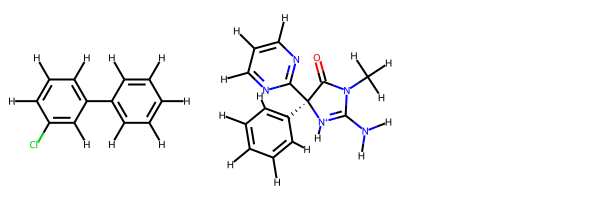

In [13]:
fragments = schema.target_molecule.fragments
rd_fragments = [fragment.to_rdkit() for fragment in fragments]
for rdmol in rd_fragments:
    rdDepictor.Compute2DCoords(rdmol)
Chem.Draw.MolsToGridImage(rd_fragments)

We can also inspect the bespoke SMIRKS that were automatically generated for this molecule by BespokeFit and check that they hit the intended atoms in both the parent and fragment. Note the SMIRKS are editable but this can cause inaccuracies during fitting if they do not transfer correctly.

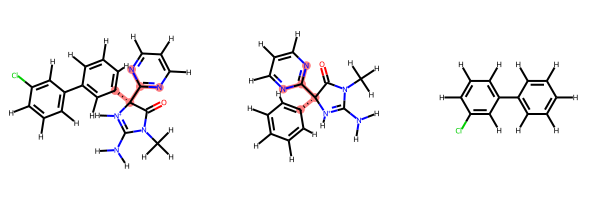

In [14]:
parameters = schema.target_smirks
parameter = parameters[2]
parent = schema.target_molecule.molecule
fragment0 = schema.target_molecule.fragment_data[0].molecule
fragment1 = schema.target_molecule.fragment_data[1].molecule

# get the smirks matches on parent and fragment
parent_matches = parent.chemical_environment_matches(parameter.smirks)
fragment1_matches = fragment1.chemical_environment_matches(parameter.smirks)
fragment0_matches = fragment0.chemical_environment_matches(parameter.smirks)
parent_matches = [atom for match in parent_matches for atom in match]
fragment1_matches = [atom for match in fragment1_matches for atom in match]
fragment0_matches = [atom for match in fragment0_matches for atom in match]

rd_mols = [parent.to_rdkit(), fragment1.to_rdkit(), fragment0.to_rdkit()]
for rdmol in rd_mols:
    rdDepictor.Compute2DCoords(rdmol)

Chem.Draw.MolsToGridImage(rd_mols, highlightAtomLists=[parent_matches, fragment1_matches, fragment0_matches])

We can also check the QC specification used to compute the reference data to ensure it is compatible with the OpenFF default.

In [15]:
schema.targets[0].reference_data.dict(exclude={"tasks"})

{'type': 'bespoke',
 'qc_spec': {'method': 'B3LYP-D3BJ',
  'basis': 'DZVP',
  'program': 'psi4',
  'spec_name': 'default',
  'spec_description': 'Standard OpenFF optimization quantum chemistry specification.',
  'store_wavefunction': 'none',
  'implicit_solvent': None,
  'keywords': None},
 'target_conformers': 4}

# 3. Loading data from QCArchive

BespokeFit was built with QCFractal/QCArchive integration in mind, allowing for the reuse of computed reference data stored in a QCArchive instance. Here we will load a torsion drive dataset from the public QCArchive that contains JACS fragments including our target molecule. 

First, we connect to the public client and list all of the available torsion drive datasets.

In [16]:
client = FractalClient()
client.list_collections("torsiondrivedataset")

tagline
collection          name                                                                                                 
TorsionDriveDataset Fragment Stability Benchmark                                                                     None
                    Fragmenter paper                                                                                 None
                    OpenFF Amide Torsion Set v1.0                       Amides, thioamides and amidines diversely func...
                    OpenFF Aniline 2D Impropers v1.0                    Substituted aniline derivatives with various e...
                    OpenFF DANCE 1 eMolecules t142 v1.0                                                              None
                    OpenFF Fragmenter Validation 1.0                                                                 None
                    OpenFF Full TorsionDrive Benchmark 1                                                             None
                    OpenFF Gen 2 Torsion Set 1 Roche                                                                 None
                    OpenFF Gen 2 Torsion Set 1 Roche 2                                                               None
                    OpenFF Gen 2 Torsion Set 2 Coverage                                                              None
                    OpenFF Gen 2 Torsion Set 2 Coverage 2                                                            None
                    OpenFF Gen 2 Torsion Set 3 Pfizer Discrepancy                                                    None
                    OpenFF Gen 2 Torsion Set 3 Pfizer Discrepancy 2                                                  None
                    OpenFF Gen 2 Torsion Set 4 eMolecules Discrepancy                                                None
                    OpenFF Gen 2 Torsion Set 4 eMolecules Discrepan...                                               None
                    OpenFF Gen 2 Torsion Set 5 Bayer                                                                 None
                    OpenFF Gen 2 Torsion Set 5 Bayer 2                                                               None
                    OpenFF Gen 2 Torsion Set 6 Supplemental                                                          None
                    OpenFF Gen 2 Torsion Set 6 Supplemental 2                                                        None
                    OpenFF Gen3 Torsion Set v1.0                                             OpenFF Gen3 Torsion Set v1.0
                    OpenFF Group1 Torsions                                                                           None
                    OpenFF Group1 Torsions 2                                                                         None
                    OpenFF Group1 Torsions 3                                                                         None
                    OpenFF Primary Benchmark 1 Torsion Set                                                           None
                    OpenFF Primary Benchmark 2 Torsion Set                                                           None
                    OpenFF Primary TorsionDrive Benchmark 1                                                          None
                    OpenFF Protein Fragments TorsionDrives v1.0         Torsiondrives for selected dihedrals of variou...
                    OpenFF Rowley Biaryl v1.0                                          Torsiondrives of biaryl molecules.
                    OpenFF Substituted Phenyl Set 1                                                                  None
                    OpenFF Substituted Phenyl Set 1 v2.0                Torsiondrives for selected dihedrals of variou...
                    OpenFF Theory Benchmarking Set B3LYP-D3BJ 6-31+Gss  Torsiondrives for benchmarking B3LYP-D3BJ/6-31...
                    OpenFF Theory Benchmarking Set B3LYP-D3BJ DZVP ...     Torsiondrives

Next, we can use [OpenFF-QCSubmit](https://github.dihe.moe/openforcefield/openff-qcsubmit/) to create a results object from a QCArchive dataset, this just wraps around the data structure and provides an interface to the openff software stack by converting the results to openff-toolkit molecule objects. 

Here we select the `OpenFF-benchmark-ligand-fragments-v1.0` dataset which we know contains the result we are looking for among many others and we choose all calculations done with the OpenFF `default` spec `B3LYP-D3BJ/DZVP`.

In [17]:
result = TorsionDriveResultCollection.from_server(client, "OpenFF-benchmark-ligand-fragments-v1.0", "default")

We can now take a look at the dataset and see how many resuls we have collected.

In [18]:
print(f"Number of uniquie molecules {result.n_molecules}")
print(f"Number of torsiondrives {result.n_results}")

Number of uniquie molecules 368
Number of torsiondrives 481


So we have 481 torsion drives across 368 unique molecules, with some molecules have multiple torsion driven. Where all scans are 1D. The dataset object contains references to the data records in the archive to keep it light, inorder to use the results we then need to pull them down and convert them into a usable format.

In [19]:
records_and_molecules = result.to_records()
record, torsion_molecule = records_and_molecules[0]

This is the raw QCArchive torsiondrive result object.

In [20]:
pprint(record.dict())

{'created_on': datetime.datetime(2020, 8, 11, 8, 41, 29, 18631),
 'error': None,
 'extras': {},
 'final_energy_dict': {'[-105]': -3640.4638158997955,
                       '[-120]': -3640.4647679341156,
                       '[-135]': -3640.465163735234,
                       '[-150]': -3640.4642715928676,
                       '[-15]': -3640.4636147417914,
                       '[-165]': -3640.4624015613344,
                       '[-30]': -3640.4652715028706,
                       '[-45]': -3640.465825944451,
                       '[-60]': -3640.4651696332535,
                       '[-75]': -3640.464054289657,
                       '[-90]': -3640.4633727497303,
                       '[0]': -3640.462376071303,
                       '[105]': -3640.463816209257,
                       '[120]': -3640.4647678395318,
                       '[135]': -3640.4651635049663,
                       '[150]': -3640.464272242762,
                       '[15]': -3640.4636146794787,
       

We can also inspect the openff-tookkit molecule with all of the conformers from the torsiondrive.

In [21]:
torsion_molecule

NGLWidget(max_frame=23)

BespokeFit can now accept the list of results objects and determine if any of the results can be used as reference data for the molecule specific fitting schema. To do this BespokeFit first determines if the molecules are the same and then works out if the target dihedrals (central bond) are the same regardless of atom ordering. Provided they are and that the reference data is computed at the requested level of theory set out in the schema the results are saved into the optimization schema. 

Here we will first check that we can not optimize our molecule as we have missing reference data.

In [22]:
schema.ready_for_fitting

False

Now we can take a look at a subset of the available data in this dataset.

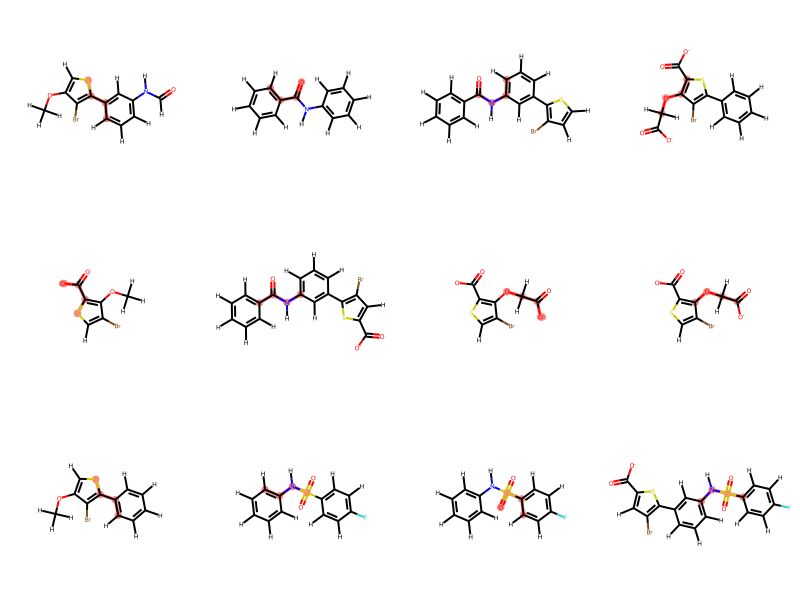

In [23]:
from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor

n_load = 12
rdmols = [entry[1].to_rdkit() for entry in records_and_molecules[:n_load]]
dihedrals = [entry[0].keywords.dihedrals[0] for entry in records_and_molecules[:n_load]]
for rdmol in rdmols:
    rdDepictor.Compute2DCoords(rdmol)
Chem.Draw.MolsToGridImage(rdmols, highlightAtomLists=dihedrals, molsPerRow=4)

We can then use the results to update the schema and check that it is ready for fitting.

In [24]:
schema.update_with_results(records_and_molecules)
print(schema.ready_for_fitting)

True


# 4. Optimize the bespoke torsion parameters

We can then use BespokeFit to either:
- Set up the ForceBalance optimization job for us to run later 
- Use the `Executor` class to set up and run the optimizations. 

Note that if we pass an incomplete schema into the `Executor` it will attempt to generate the missing data on the fly using a local QCFractal instance. See section 6 for more information.

In [25]:
executor = Executor()

In [26]:
result = executor.execute(schema)

  0%|          | 0/3 [00:00<?, ?it/s]

generating target directory for torsion-21540558
Note: Failed to import the optional openff.evaluator package. 
Note: Failed to import the optional openff.recharge package.


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]
Killing all workers


generating target directory for torsion-21540571
generating target directory for torsion-21540570


In [27]:
# if you could not run the fitting load the result here
# result = deserialize_results("bace_result.json.xz")

# 5.  Analysis of the results

Once the torsion optimization is complete a results schema is returned. The schema contains the final optimized SMIRKS parameters that can be used with the [OpenFF-Toolkit](https://github.com/openforcefield/openff-toolkit) in workflows to parameterize molecules and set up systems in [OpenMM](https://github.com/openmm/openmm) to run dynamics. The results schema also contains all provenance information which can help with reproducibility. 

First, let's look at the final output.

In [28]:
from IPython.display import IFrame
IFrame("bespoke_task_0/optimize.tmp/torsion-21540570/iter_0002/plot_torsion.pdf", width=900, height=600)

BespokeFit has been successful as there is a clear improvement in the PES around this torsion. We can also plot how the parameters have changed during optimization as the result schema stores the initial and final torsion parameters.

In [31]:
# collect the before, after and change values
import pandas as pd

parameter_data = []
for i, parameter in enumerate(result[0].input_schema.target_smirks):
    for final_parameter in result[0].final_smirks:
        if parameter.smirks == final_parameter.smirks:
            for term in range(1, 5):
                k_before = float(parameter.terms[str(term)].k.split()[0])
                k_after = float(final_parameter.terms[str(term)].k.split()[0])
                parameter_data.append([f"smirks_{i}_k{term}", k_before, k_after, k_after - k_before])

# make a pandas dataframe
df = pd.DataFrame(parameter_data, columns=["parameter", "before", "after", "change"])
df

,parameter,before,after,change
0,smirks_0_k1,0.000001,9.806344e-07,-1.936555e-08
1,smirks_0_k2,1.048715,1.048700e+00,-1.535682e-05
2,smirks_0_k3,0.000001,9.303023e-07,-6.969771e-08
3,smirks_0_k4,0.000001,1.706715e-05,1.606715e-05
4,smirks_1_k1,0.000001,1.016282e-06,1.628199e-08
5,smirks_1_k2,1.048715,8.485675e-01,-2.001476e-01
6,smirks_1_k3,0.000001,9.594064e-07,-4.059361e-08
7,smirks_1_k4,0.000001,2.109176e-02,2.109076e-02
8,smirks_2_k1,0.000001,9.313379e-07,-6.866208e-08
9,smirks_2_k2,0.000001,-8.833812e-02,-8.833912e-02


BespokeFit introduces many redundant parameters into the fitting, so we only plot arrows for terms that have changed by more than 1e-3 kcal/mol. 

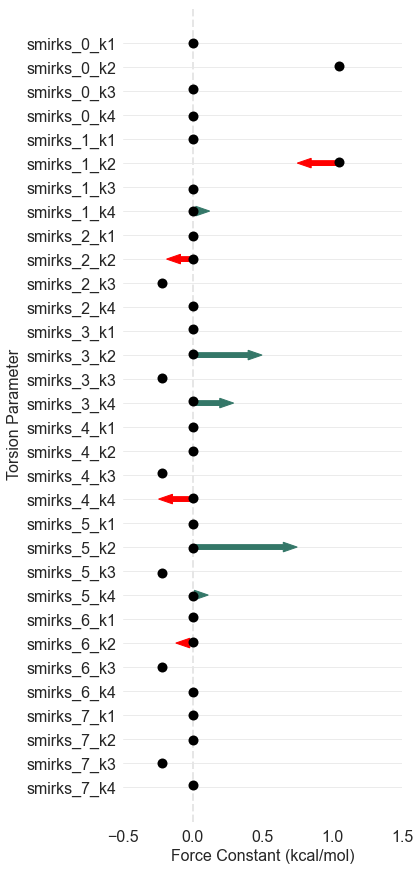

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#initialize a plot
ax = plt.figure(figsize=(5,15))
#add start points
ax = sns.stripplot(data=df, 
                   x='before', 
                   y='parameter', 
                   orient='h', 
                   order=df['parameter'], 
                   size=10, 
                   color='black')
ax.grid(axis='y', color='0.9') 
#add arrows to plot only if the parameter changed by more than 1e-3 kcal/mol
for i in range(len(df.index)):
    term = df.iloc[i]
    if abs(term["change"]) > 1e-3:
        if term["after"] > term["before"]:
            arrow_color = '#347768'
        elif term["after"] < term["before"]:
            arrow_color = 'red'
        else:
            arrow_color = 'black'
        ax.arrow(term["before"],        #x start point
                 i,                      #y start point
                 term["change"],       #change in x 
                 0,                      #change in y
                 head_width=0.4,         #arrow head width
                 head_length=0.1,        #arrow head length
                 width=0.2,              #arrow stem width
                 fc=arrow_color,             #arrow fill color
                 ec=arrow_color)     
ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0)
ax.set_xlim(-0.5,1.5) 
ax.set_xlabel('Force Constant (kcal/mol)')                               
ax.set_ylabel('Torsion Parameter')                         
sns.despine(left=True, bottom=True) 

We can now parameterize the parent molecule using the final force field to ensure the correct torsion parameters are applied.

First, we construct the final force field that is the reference force field, in this case, `openff_unconstrained-1.3.0.offxml` supplemented with the new bespoke parameters and then label the molecule.

In [34]:
bespoke_ff = result[0].get_final_force_field(drop_out_value=1e-5)
torsion_labels = bespoke_ff.label_molecules(schema.target_molecule.molecule.to_topology())[0]["ProperTorsions"]
for torsion, parameter in torsion_labels.items():
    print(torsion, parameter)

(0, 1, 2, 3) <ProperTorsionType with smirks: [*:1]~[#6X3:2]:[#6X3:3]~[*:4]  periodicity1: 2  phase1: 180.0 deg  id: t44  k1: 3.739199932852 kcal/mol  idivf1: 1.0  >
(0, 1, 2, 43) <ProperTorsionType with smirks: [*:1]~[#6X3:2]:[#6X3:3]~[*:4]  periodicity1: 2  phase1: 180.0 deg  id: t44  k1: 3.739199932852 kcal/mol  idivf1: 1.0  >
(0, 1, 6, 5) <ProperTorsionType with smirks: [*:1]~[#6X3:2]:[#6X3:3]~[*:4]  periodicity1: 2  phase1: 180.0 deg  id: t44  k1: 3.739199932852 kcal/mol  idivf1: 1.0  >
(0, 1, 6, 7) <ProperTorsionType with smirks: [*:1]~[#6X3:2]:[#6X3:3]~[*:4]  periodicity1: 2  phase1: 180.0 deg  id: t44  k1: 3.739199932852 kcal/mol  idivf1: 1.0  >
(1, 2, 3, 4) <ProperTorsionType with smirks: [*:1]~[#6X3:2]:[#6X3:3]~[*:4]  periodicity1: 2  phase1: 180.0 deg  id: t44  k1: 3.739199932852 kcal/mol  idivf1: 1.0  >
(1, 2, 3, 32) <ProperTorsionType with smirks: [*:1]~[#6X3:2]:[#6X3:3]~[*:4]  periodicity1: 2  phase1: 180.0 deg  id: t44  k1: 3.739199932852 kcal/mol  idivf1: 1.0  >
(1, 6, 5

# 6. QC data generation on the fly

In most cases, you will not have the QC data pre-generated before running and will need to generate it before fitting. Here we will show how the BespokeFit `Executor` can do this by either connecting to a running QCFractal service or starting a new local SnowFlake instance. 

For the sake of time, a semiempirical tight-binding method available in [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html), will be used to generate the reference data. 

Due to BespokeFits integration with QCEngine any currently supported program in QCEngine can generate the reference data, and selecting the method is as simple as configuring the `QCSpec` schema.

First, let's create the compute specification we wish to use for the calculation.

In [35]:
xtb_spec = QCSpec(method="gfn2xtb", basis=None, program="xtb", spec_name="xtb_gfn2", spec_description="A fast semi-emperical calculation.")
pprint(xtb_spec.dict())

{'basis': None,
 'implicit_solvent': None,
 'keywords': None,
 'method': 'gfn2xtb',
 'program': 'xtb',
 'spec_description': 'A fast semi-emperical calculation.',
 'spec_name': 'xtb_gfn2',
 'store_wavefunction': 'none'}


By default or target templates will try to use the openff default QC specification to ensure compatibility so here we need to overwrite this.

In [36]:
target = TorsionProfileTargetSchema(reference_data=BespokeQCData(qc_spec=xtb_spec))
xtb_workflow = BespokeWorkflowFactory(target_templates=[target, ])
pprint(xtb_workflow.dict())

{'expand_torsion_terms': True,
 'fragmentation_engine': {'keep_non_rotor_ring_substituents': True,
                          'target_bond_smarts': None,
                          'type': 'WBOFragmenter',
                          'wbo_threshold': 0.03},
 'generate_bespoke_terms': True,
 'initial_force_field': 'openff_unconstrained-1.3.0.offxml',
 'optimizer': {'adaptive_damping': 1.0,
               'adaptive_factor': 0.2,
               'eigenvalue_lower_bound': 0.01,
               'error_tolerance': 1.0,
               'extras': {},
               'finite_difference_h': 0.01,
               'gradient_convergence_threshold': 0.01,
               'initial_trust_radius': -0.25,
               'job_type': 'optimize',
               'max_iterations': 10,
               'minimum_trust_radius': 0.05,
               'n_criteria': 2,
               'normalize_weights': False,
               'objective_convergence_threshold': 0.01,
               'penalty_additive': 1.0,
               'penal

For this example, we are going to be using a very small molecule `BrCO` for speed which does not normally pass the fragmentation stage as openff-fragmenter will not fragment around terminal rotatable bonds so here we need to overwrite that as well.

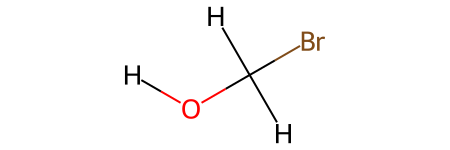

In [37]:
xtb_workflow.fragmentation_engine.target_bond_smarts = ["[!$(*#*)&!D1:1]-,=;!@[!$(*#*)&!D1:2]", ]
target_molecule = Molecule.from_smiles("BrCO")
target_molecule

Make the molecule specific optimization schema with the xTB specification.

In [38]:
xtb_schema = xtb_workflow.optimization_schema_from_molecule(target_molecule)
xtb_schema.id = "xtb_BrCO"

Start a notebook friendly SnowFlake server for the reference data generation and pass it to BespokeFit.

In [39]:
from qcfractal import FractalSnowflakeHandler

server = FractalSnowflakeHandler()
client = FractalClient(server)
print(client)

FractalClient(server_name='FractalSnowFlake_db_fad8d', address='https://localhost:62404/', username='None')


In [40]:
executor = Executor()

In [41]:
xtb_result = executor.execute(xtb_schema, client=client)

/Users/joshuahorton/miniconda3/envs/bespoke/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/joshuahorton/miniconda3/envs/bespoke/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/joshuahorton/miniconda3/envs/bespoke/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warn

generating target directory for torsion-1
Note: Failed to import the optional openff.evaluator package. 
Note: Failed to import the optional openff.recharge package.


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
Killing all workers


We can now inspect the server and view the new reference data.

In [42]:
client.list_collections()

,,tagline
collection,name,
TorsionDriveDataset,OpenFF Bespoke-fit,A bespoke QC data set


In [43]:
ds = client.get_collection("torsiondrivedataset", "OpenFF Bespoke-fit")
record = ds.get_record(ds.df.index[0], specification="xtb_gfn2")
record.visualize()

Let's repeat the analysis from above and view the PES and the change in the torsion parameters.

In [44]:
IFrame("xtb_BrCO/optimize.tmp/torsion-1/iter_0002/plot_torsion.pdf", width=900, height=600)

In [52]:
# if the xtb fitting could not be ran, uncomment this to load the results
# xtb_result = deserialize_results("xtb_result.json.xz")

In [53]:
# collect the before, after and change values
import pandas as pd

parameter_data = []
for i, parameter in enumerate(xtb_result[0].input_schema.target_smirks):
    for final_parameter in xtb_result[0].final_smirks:
        if parameter.smirks == final_parameter.smirks:
            for term in range(1, 5):
                k_before = float(parameter.terms[str(term)].k.split()[0])
                k_after = float(final_parameter.terms[str(term)].k.split()[0])
                parameter_data.append([f"smirks_{i}_k{term}", k_before, k_after, k_after - k_before])

# make a pandas dataframe
df = pd.DataFrame(parameter_data, columns=["parameter", "before", "after", "change"])
df

,parameter,before,after,change
0,smirks_0_k1,0.000001,0.000006,0.000005
1,smirks_0_k2,0.000001,0.000031,0.000030
2,smirks_0_k3,0.698594,0.212406,-0.486187
3,smirks_0_k4,0.000001,-0.059075,-0.059076
4,smirks_1_k1,0.000001,-0.000004,-0.000005
5,smirks_1_k2,0.000001,-2.134337,-2.134338
6,smirks_1_k3,0.698594,0.698590,-0.000004
7,smirks_1_k4,0.000001,0.000012,0.000011


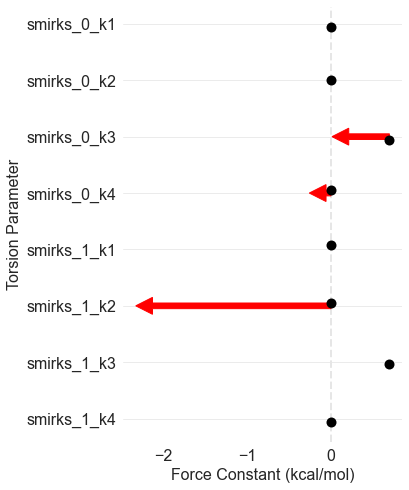

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#initialize a plot
ax = plt.figure(figsize=(5,8))
#add start points
ax = sns.stripplot(data=df, 
                   x='before', 
                   y='parameter', 
                   orient='h', 
                   order=df['parameter'], 
                   size=10, 
                   color='black')
ax.grid(axis='y', color='0.9') 
#add arrows to plot only if the parameter changed by more than 1e-3 kcal/mol
for i in range(len(df.index)):
    term = df.iloc[i]
    if abs(term["change"]) > 1e-3:
        if term["after"] > term["before"]:
            arrow_color = '#347768'
        elif term["after"] < term["before"]:
            arrow_color = 'red'
        else:
            arrow_color = 'black'
        ax.arrow(term["before"],        #x start point
                 i,                      #y start point
                 term["change"],       #change in x 
                 0,                      #change in y
                 head_width=0.3,         #arrow head width
                 head_length=0.2,        #arrow head length
                 width=0.1,              #arrow stem width
                 fc=arrow_color,             #arrow fill color
                 ec=arrow_color)     
ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0)
ax.set_xlabel('Force Constant (kcal/mol)')                               
ax.set_ylabel('Torsion Parameter')                         
sns.despine(left=True, bottom=True) 